In [1]:
### Librerias
import pandas as pd
import numpy as np
import scipy.stats as st    
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import poisson

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

from sklearn.model_selection import GridSearchCV
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#datos procesados en crudo
data_raw= pd.read_excel("data.xlsx")
dt = pd.DataFrame(data_raw)
dt

,pilot_index,LapTime,carPosition,currentLapNum,GP,driverId
0,0,92.11968,16,1,Mexico,Pierre Gasly
1,0,82.83808,17,2,Mexico,Pierre Gasly
2,0,83.18610,16,3,Mexico,Pierre Gasly
3,0,83.25229,15,4,Mexico,Pierre Gasly
4,0,83.40625,14,5,Mexico,Pierre Gasly
...,...,...,...,...,...,...
12904,19,97.41235,1,25,Austin,Valtteri Bottas
12905,19,97.20898,1,26,Austin,Valtteri Bottas
12906,19,97.19995,1,27,Austin,Valtteri Bottas
12907,19,95.96313,1,28,Austin,Valtteri Bottas


In [3]:
def datos_nodos(l:'lista de nombres de GP',dt:'dataFrame con todos los datos'):
    a = dt[dt['GP'] == l[0]]
    b = dt[dt['GP'] == l[1]]
    c = dt[dt['GP'] == l[2]]
    d = dt[dt['GP'] == l[3]]
    return a,b,c,d

In [4]:
# Datos tentativos para nodos
l = ['Monza','Monaco','Silverstone','Spa']
Monza_GP, Monaco_GP, Silverstone_GP, Spa_GP = datos_nodos(l,dt)

In [5]:
dataframes = [Monza_GP, Monaco_GP, Silverstone_GP, Spa_GP]
for df in dataframes:
    df.drop('pilot_index', axis=1, inplace=True)

## Piloto más probable a ganar el GP
### <font color='navy'> Nodos 3 & 4.

## Silverstone

In [6]:
Silverstone = Silverstone_GP.groupby('driverId')['carPosition'].mean()

In [7]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

# Crear un diccionario para almacenar los resultados de ajuste de cada distribución
resultados = {}

# Iterar a través de las distribuciones y ajustar a los datos de LapTime para cada piloto
for dist_name in dist_list:
    # Crear un DataFrame para almacenar los parámetros de ajuste para cada piloto
    params_df = pd.DataFrame(columns=['Piloto', 'Parametros'])
    
    for piloto in Silverstone_GP['driverId'].unique():
        datos_piloto = Silverstone_GP[Silverstone_GP['driverId'] == piloto]['carPosition']
        params = getattr(st, dist_name).fit(datos_piloto)
        params_df = params_df.append({'Piloto': piloto, 'Parametros': params}, ignore_index=True)
    
    resultados[dist_name] = params_df

# Obtener la media de cada distribución para cada piloto
medias = {}
for dist_name, params_df in resultados.items():
    params_df['Media'] = params_df['Parametros'].apply(lambda x: np.mean(x))
    piloto_ganador = params_df[params_df['Media'] == params_df['Media'].min()]['Piloto'].values[0]
    medias[dist_name] = (piloto_ganador, params_df['Media'].min())

# Determinar la distribución con la media más baja (es decir, el piloto más probable a ganar)
mejor_dist = min(medias, key=lambda x: medias[x][1])

print(f"La distribución {mejor_dist} tiene al piloto {medias[mejor_dist][0]} como el más probable a ganar.")

La distribución foldnorm tiene al piloto Sergio Perez como el más probable a ganar.


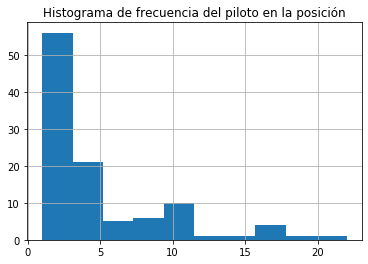

In [8]:
plt.title('Histograma de frecuencia del piloto en la posición')
Silverstone_GP.groupby(['driverId','carPosition'])['GP'].count().hist()

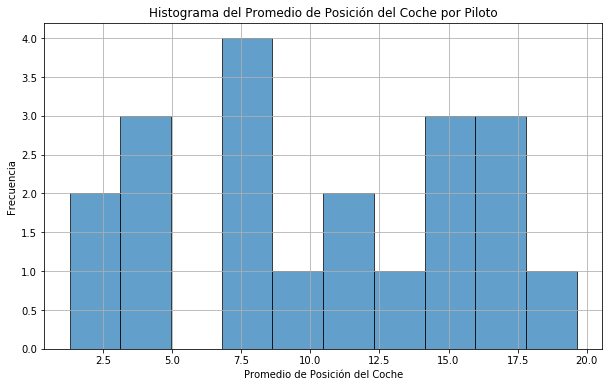

In [9]:
# Calcula el promedio de la posición del coche para cada piloto
promedio_posicion3 = Silverstone_GP.groupby('driverId')['carPosition'].mean()

# Crea un histograma del promedio de la posición del coche
plt.figure(figsize=(10, 6))
plt.hist(promedio_posicion3, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Promedio de Posición del Coche')
plt.ylabel('Frecuencia')
plt.title('Histograma del Promedio de Posición del Coche por Piloto')
plt.grid(True)
plt.show()

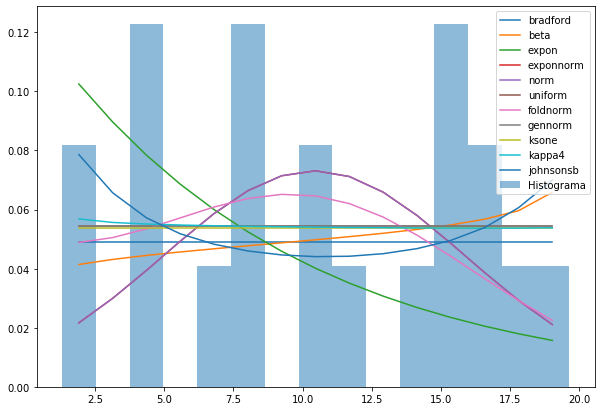

   distribución     error
0      bradford  0.001961
1          beta  0.001993
2         expon  0.002679
3     exponnorm  0.002398
4          norm  0.002398
5       uniform  0.001932
6      foldnorm  0.002175
7       gennorm  0.001932
8         ksone  0.001932
9        kappa4   0.00193
10    johnsonsb  0.002005


In [10]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y, x = np.histogram(promedio_posicion3, bins=15, density=True)
x = (x + np.roll(x, -1))[:-1] / 2

i = 0
error_df = pd.DataFrame(columns=['distribución', 'error'])

for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion3)
    y_hat = getattr(st, d).pdf(x, *param)
    error = np.mean((y - y_hat) ** 2)
    error_df.loc[i, 'distribución'] = d
    error_df.loc[i, 'error'] = error
    i += 1

# Ajusta el ancho de las barras del histograma
width = x[1] - x[0]

# Dibuja el histograma
ax.bar(x, y, width=width, alpha=0.5, label='Histograma')

# Dibuja las líneas de las distribuciones
for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion3)
    y_hat = getattr(st, d).pdf(x, *param)
    ax.plot(x, y_hat, label=f'{d}')

plt.legend()
plt.show()

# Error cuadrático medio para cada distribución
print(error_df)

In [11]:
#Parámetros de distibución uniform en nuestros datos
params_Silverstone = st.uniform.fit(promedio_posicion3)
params_Silverstone

(1.2962962962962963, 18.343703703703703)

In [12]:
# Prueba de hipótesis
st.kstest(promedio_posicion3, lambda promedio_posicion3: st.uniform.cdf(promedio_posicion3,*params_Silverstone))

KstestResult(statistic=0.09422176111725455, pvalue=0.9942875298876577)

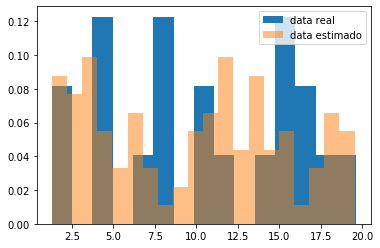

In [13]:
dist = 'uniform'
params3 = getattr(st, dist).fit(promedio_posicion3)

random_hat3 = getattr(st, dist).rvs(*params3, size = 100)

plt.hist(promedio_posicion3, bins =15, label = 'data real', density = True)
plt.hist(random_hat3, bins = 20, density = True, alpha = .5, label = 'data estimado')
plt.legend()
plt.show()

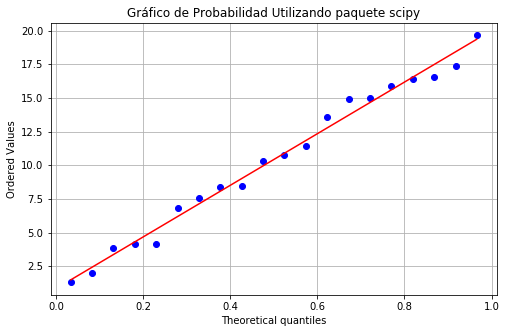

In [14]:
divisiones = 20
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

grap2 = st.probplot(promedio_posicion3, dist='uniform', sparams=getattr(st, 'uniform').fit(promedio_posicion3)[:-2], plot=ax, fit=True)
ax.grid()
ax.set_title('Gráfico de Probabilidad Utilizando paquete scipy')

plt.show()

## Spa

In [15]:
Spa = Spa_GP.groupby('driverId')['carPosition'].mean()

In [16]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

# Crear un diccionario para almacenar los resultados de ajuste de cada distribución
resultados = {}

# Iterar a través de las distribuciones y ajustar a los datos de LapTime para cada piloto
for dist_name in dist_list:
    # Crear un DataFrame para almacenar los parámetros de ajuste para cada piloto
    params_df = pd.DataFrame(columns=['Piloto', 'Parametros'])
    
    for piloto in Spa_GP['driverId'].unique():
        datos_piloto = Spa_GP[Spa_GP['driverId'] == piloto]['carPosition']
        params = getattr(st, dist_name).fit(datos_piloto)
        params_df = params_df.append({'Piloto': piloto, 'Parametros': params}, ignore_index=True)
    
    resultados[dist_name] = params_df

# Obtener la media de cada distribución para cada piloto
medias = {}
for dist_name, params_df in resultados.items():
    params_df['Media'] = params_df['Parametros'].apply(lambda x: np.mean(x))
    piloto_ganador = params_df[params_df['Media'] == params_df['Media'].min()]['Piloto'].values[0]
    medias[dist_name] = (piloto_ganador, params_df['Media'].min())

# Determinar la distribución con la media más baja (es decir, el piloto más probable a ganar)
mejor_dist = min(medias, key=lambda x: medias[x][1])

print(f"La distribución {mejor_dist} tiene al piloto {medias[mejor_dist][0]} como el más probable a ganar.")

La distribución johnsonsb tiene al piloto Charles Leclerc como el más probable a ganar.


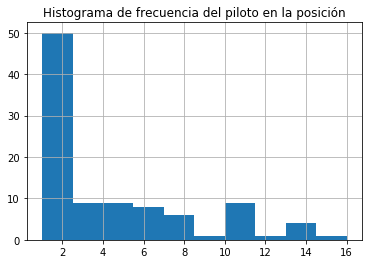

In [17]:
plt.title('Histograma de frecuencia del piloto en la posición')
Spa_GP.groupby(['driverId','carPosition'])['GP'].count().hist()

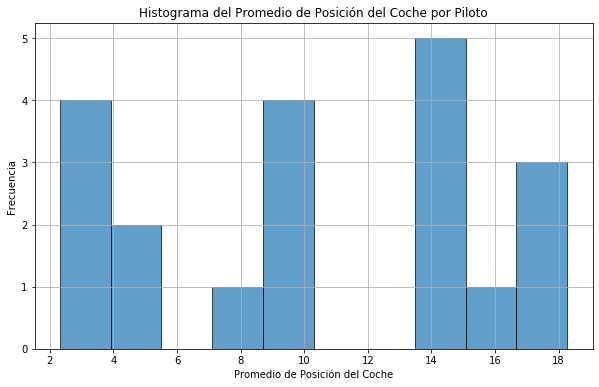

In [18]:
# Calcula el promedio de la posición del coche para cada piloto
promedio_posicion4 = Spa_GP.groupby('driverId')['carPosition'].mean()

# Crea un histograma del promedio de la posición del coche
plt.figure(figsize=(10, 6))
plt.hist(promedio_posicion4, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Promedio de Posición del Coche')
plt.ylabel('Frecuencia')
plt.title('Histograma del Promedio de Posición del Coche por Piloto')
plt.grid(True)
plt.show()

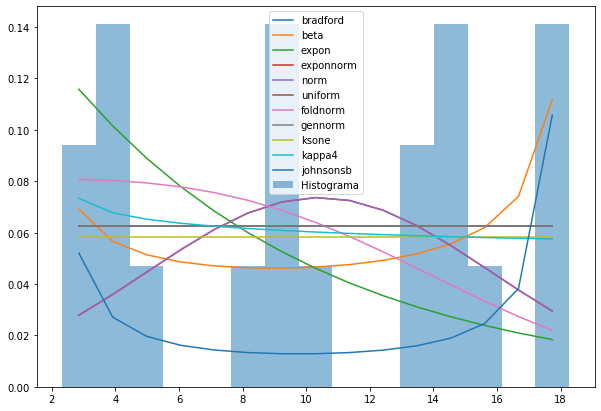

   distribución     error
0      bradford  0.003143
1          beta  0.002778
2         expon  0.003892
3     exponnorm   0.00401
4          norm   0.00401
5       uniform  0.003143
6      foldnorm  0.003782
7       gennorm  0.003143
8         ksone  0.003163
9        kappa4  0.003098
10    johnsonsb  0.003951


In [19]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y, x = np.histogram(promedio_posicion4, bins=15, density=True)
x = (x + np.roll(x, -1))[:-1] / 2

i = 0
error_df = pd.DataFrame(columns=['distribución', 'error'])

for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion4)
    y_hat = getattr(st, d).pdf(x, *param)
    error = np.mean((y - y_hat) ** 2)
    error_df.loc[i, 'distribución'] = d
    error_df.loc[i, 'error'] = error
    i += 1

# Ajusta el ancho de las barras del histograma
width = x[1] - x[0]

# Dibuja el histograma
ax.bar(x, y, width=width, alpha=0.5, label='Histograma')

# Dibuja las líneas de las distribuciones
for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion4)
    y_hat = getattr(st, d).pdf(x, *param)
    ax.plot(x, y_hat, label=f'{d}')

plt.legend()
plt.show()

# Error cuadrático medio para cada distribución
print(error_df)

In [20]:
#Parámetros de distibución kappa4 en nuestros datos
params_Spa = st.beta.fit(promedio_posicion4)
params_Spa

(0.704205001096176, 0.6075928940169874, 1.9327157379012636, 16.340011534826015)

In [21]:
# Prueba de hipótesis
st.kstest(promedio_posicion4, lambda promedio_posicion4: st.beta.cdf(promedio_posicion4,*params_Spa))

KstestResult(statistic=0.11618278003372551, pvalue=0.950019726258192)

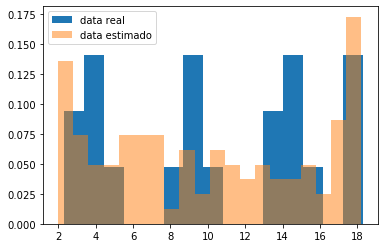

In [22]:
dist = 'beta'
params4 = getattr(st, dist).fit(promedio_posicion4)

random_hat4 = getattr(st, dist).rvs(*params4, size = 100)

plt.hist(promedio_posicion4, bins =15, label = 'data real', density = True)
plt.hist(random_hat4, bins = 20, density = True, alpha = .5, label = 'data estimado')
plt.legend()
plt.show()

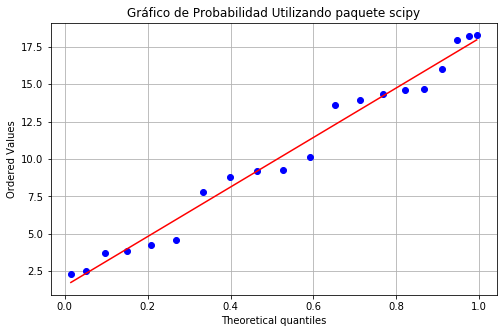

In [23]:
divisiones = 20
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

grap3 = st.probplot(promedio_posicion4, dist='beta', sparams=getattr(st, 'beta').fit(promedio_posicion4)[:-2], plot=ax, fit=True)
ax.grid()
ax.set_title('Gráfico de Probabilidad Utilizando paquete scipy')

plt.show()

## Simulación

## Silverstone 

In [24]:
# Ajusta la distribución kappa4 a los datos de Monza
dist_name = 'uniform'
param = st.uniform.fit(promedio_posicion3)

# Simula 10000 escenarios de tiempo de vuelta con la distribución kappa4
num_simulaciones = 10000
tiempos_simulados = st.uniform.rvs(*param, size=num_simulaciones)

# Crea un DataFrame para almacenar los resultados
resultados_simulacion = pd.DataFrame(columns=['Piloto', 'Tiempo'])

for i in range(num_simulaciones):
    # Obtiene el tiempo simulado
    tiempo_simulado = tiempos_simulados[i]
    
    # Encuentra al piloto ganador en el escenario simulado
    piloto_ganador = Silverstone_GP[Silverstone_GP['carPosition'] == Silverstone_GP['carPosition'].min()]['driverId'].values[0]
    
    # Agrega los resultados a DataFrame
    resultados_simulacion = resultados_simulacion.append({'Piloto': piloto_ganador, 'Tiempo': tiempo_simulado}, ignore_index=True)

# Ordena los pilotos ganadores por tiempo simulado
resultados_simulacion = resultados_simulacion.sort_values(by='Tiempo')

# Obtiene el piloto más probable a ganar en el primer escenario simulado
piloto_mas_probable_a_ganar = resultados_simulacion.iloc[0]['Piloto']

print(f"El piloto más probable a ganar en Silverstone en los 10,000 escenarios simulados es el piloto con driverId: {piloto_mas_probable_a_ganar}")

El piloto más probable a ganar en Silverstone en los 10,000 escenarios simulados es el piloto con driverId: Lewis Hamilton


In [25]:
# Ajusta la distribución uniform a los datos de Silverstone
dist_name = 'uniform'
param = st.uniform.fit(promedio_posicion3)

# Simula 1000 escenarios de tiempo de vuelta con la distribución uniform
num_simulaciones = 10000
tiempos_simulados = st.uniform.rvs(*param, size=num_simulaciones)

# Determina el piloto ganador en cada escenario simulado
piloto_ganador_simulaciones = []

for _ in range(num_simulaciones):
    tiempo_simulado = st.uniform.rvs(*param)
    piloto_ganador_simulaciones.append((tiempo_simulado, Silverstone_GP[Silverstone_GP['carPosition'] == min(Silverstone_GP['carPosition'])]['driverId'].values[0]))

# Ordena los pilotos ganadores por tiempo simulado
piloto_ganador_simulaciones.sort(key=lambda x: x[0])

# El piloto más probable a ganar en Silverstone en el primer escenario simulado
piloto_mas_probable_a_ganar = piloto_ganador_simulaciones[0][1]

print(f"El piloto más probable a ganar en Silverstone es: {piloto_mas_probable_a_ganar}")

El piloto más probable a ganar en Silverstone es: Lewis Hamilton


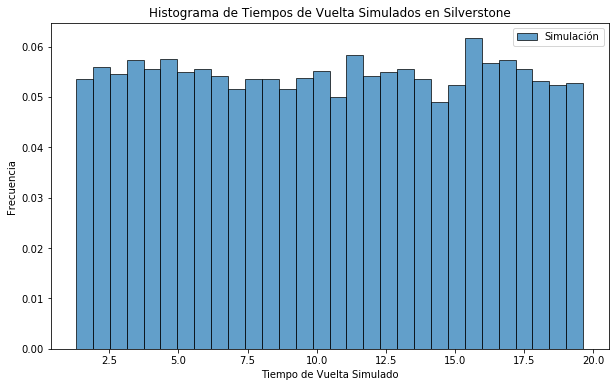

In [26]:
# Crea un histograma de los tiempos simulados
plt.figure(figsize=(10, 6))
plt.hist(tiempos_simulados, bins=30, edgecolor='black', alpha=0.7, density=True, label='Simulación')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Frecuencia')
plt.title('Histograma de Tiempos de Vuelta Simulados en Silverstone')
plt.legend()
plt.show()

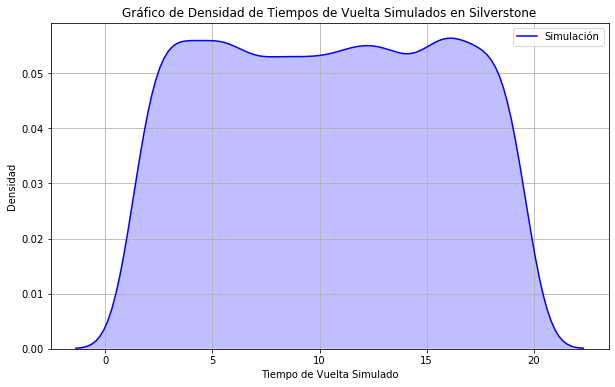

In [27]:
# Crea un gráfico de densidad KDE para los tiempos de vuelta simulados
plt.figure(figsize=(10, 6))
sns.kdeplot(tiempos_simulados, shade=True, label='Simulación', color='blue')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.title('Gráfico de Densidad de Tiempos de Vuelta Simulados en Silverstone')
plt.legend()
plt.grid(True)
plt.show()

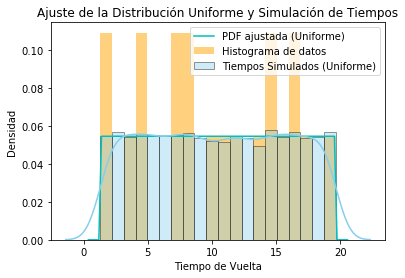

In [28]:
# Ajuste de la distribución uniforme a los datos
param_uniform = st.uniform.fit(promedio_posicion3)

# Histograma de los datos
plt.hist(promedio_posicion3, bins=20, density=True, alpha=0.5, color='orange', label='Histograma de datos')

# Función de densidad ajustada (PDF uniforme)
xmin, xmax = plt.xlim()
x_uniform = np.linspace(xmin, xmax, 100)
pdf_fitted_uniform = st.uniform.pdf(x_uniform, *param_uniform)
plt.plot(x_uniform, pdf_fitted_uniform, 'c-', label='PDF ajustada (Uniforme)')

# Simulación de escenarios de tiempo de vuelta con la distribución uniforme
num_simulaciones = 10000
tiempos_simulados_uniform = st.uniform.rvs(*param_uniform, size=num_simulaciones)

# Histograma de los tiempos simulados
sns.distplot(tiempos_simulados_uniform, bins=20, kde=True, color='skyblue', hist_kws={'edgecolor': 'black'}, label='Tiempos Simulados (Uniforme)')

# Etiquetas y título
plt.title('Ajuste de la Distribución Uniforme y Simulación de Tiempos')
plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad')
plt.legend()
plt.show()


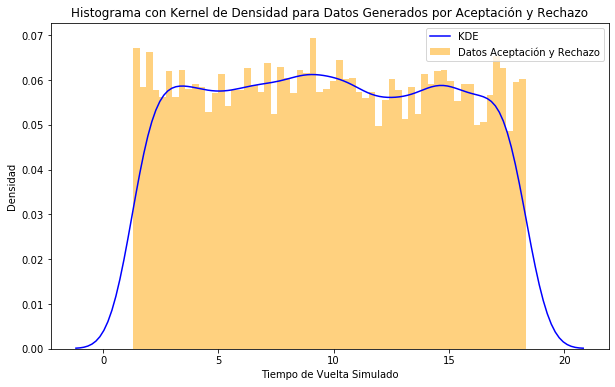

In [29]:
# Ajusta la distribución kappa4 a los datos de Monza
dist_name = 'uniform'
param = st.uniform.fit(promedio_posicion3)

# Simula 10000 escenarios de tiempo de vuelta con la distribución kappa4
num_simulaciones = 10000
tiempos_simulados = st.uniform.rvs(*param, size=num_simulaciones)

# Genera datos para el método de aceptación y rechazo
aceptados = []
rechazados = []

# Usa el método de aceptación y rechazo para generar datos
for i in range(num_simulaciones):
    propuesta = np.random.uniform(*param)
    f_propuesta = st.uniform.pdf(propuesta, *param)
    u = np.random.uniform(0, st.uniform.pdf(param[1], *param))

    if u <= f_propuesta:
        aceptados.append(propuesta)
    else:
        rechazados.append(propuesta)

# Crea un histograma con kernel de densidad para los datos generados
plt.figure(figsize=(10, 6))

# Histograma
plt.hist(aceptados, bins=60, density=True, alpha=0.5, color='orange', label='Datos Aceptación y Rechazo')

# KDE
sns.kdeplot(aceptados, color='blue', label='KDE')

# Añade etiquetas y título al gráfico
plt.title('Histograma con Kernel de Densidad para Datos Generados por Aceptación y Rechazo')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.legend()

# Muestra el gráfico
plt.show()

## Spa

In [30]:
# Ajusta la distribución beta a los datos de Spa
dist_name = 'beta'
param = st.beta.fit(promedio_posicion4)

# Simula 1000 escenarios de tiempo de vuelta con la distribución beta
num_simulaciones = 10000
tiempos_simulados = st.beta.rvs(*param, size=num_simulaciones)

# Determina el piloto ganador en cada escenario simulado
piloto_ganador_simulaciones = []

for _ in range(num_simulaciones):
    tiempo_simulado = st.beta.rvs(*param)
    piloto_ganador_simulaciones.append((tiempo_simulado, Spa_GP[Spa_GP['carPosition'] == min(Spa_GP['carPosition'])]['driverId'].values[0]))

# Ordena los pilotos ganadores por tiempo simulado
piloto_ganador_simulaciones.sort(key=lambda x: x[0])

# El piloto más probable a ganar en Monza en el primer escenario simulado
piloto_mas_probable_a_ganar = piloto_ganador_simulaciones[0][1]

print(f"El piloto más probable a ganar en Spa es: {piloto_mas_probable_a_ganar}")

El piloto más probable a ganar en Spa es: Max Verstappen


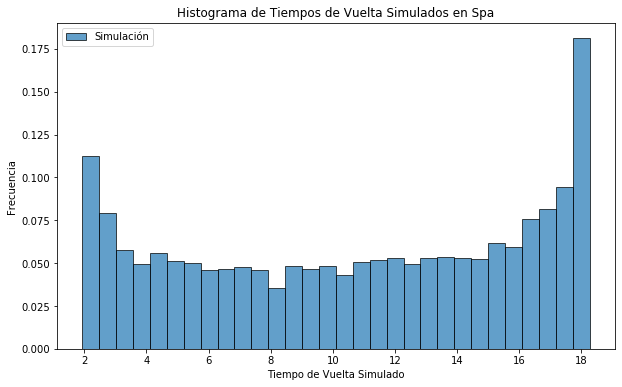

In [31]:
# Crea un histograma de los tiempos simulados
plt.figure(figsize=(10, 6))
plt.hist(tiempos_simulados, bins=30, edgecolor='black', alpha=0.7, density=True, label='Simulación')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Frecuencia')
plt.title('Histograma de Tiempos de Vuelta Simulados en Spa')
plt.legend()
plt.show()

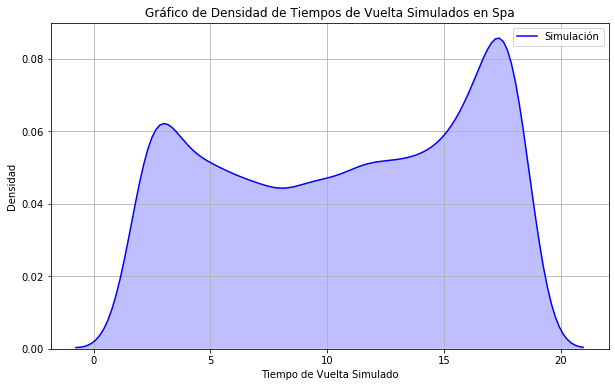

In [32]:
# Crea un gráfico de densidad KDE para los tiempos de vuelta simulados
plt.figure(figsize=(10, 6))
sns.kdeplot(tiempos_simulados, shade=True, label='Simulación', color='blue')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.title('Gráfico de Densidad de Tiempos de Vuelta Simulados en Spa')
plt.legend()
plt.grid(True)
plt.show()

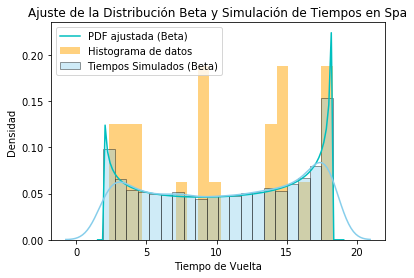

In [33]:
# Ajuste de la distribución beta a los datos de Spa
param_beta = st.beta.fit(promedio_posicion4)

# Histograma de los datos
plt.hist(promedio_posicion4, bins=20, density=True, alpha=0.5, color='orange', label='Histograma de datos')

# Función de densidad ajustada (PDF beta)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf_fitted_beta = st.beta.pdf(x, *param_beta)
plt.plot(x, pdf_fitted_beta, 'c-', label='PDF ajustada (Beta)')

# Simulación de escenarios de tiempo de vuelta con la distribución beta
num_simulaciones = 10000
tiempos_simulados_beta = st.beta.rvs(*param_beta, size=num_simulaciones)

# Histograma de los tiempos simulados
sns.distplot(tiempos_simulados_beta, bins=20, kde=True, color='skyblue', hist_kws={'edgecolor': 'black'}, label='Tiempos Simulados (Beta)')

# Etiquetas y título
plt.title('Ajuste de la Distribución Beta y Simulación de Tiempos en Spa')
plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad')
plt.legend()
plt.show()

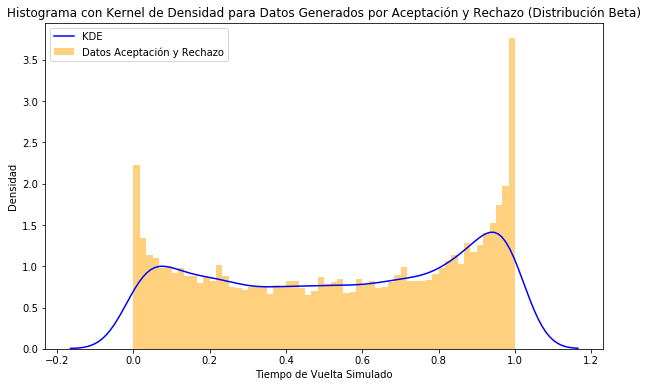

In [34]:
# Ajusta la distribución beta a los datos de Monza
dist_name = 'beta'
param = st.beta.fit(promedio_posicion4)

# Simula 10000 escenarios de tiempo de vuelta con la distribución beta
num_simulaciones = 10000
tiempos_simulados = st.beta.rvs(*param, size=num_simulaciones)

# Genera datos para el método de aceptación y rechazo
aceptados = []
rechazados = []

# Usa el método de aceptación y rechazo para generar datos
for i in range(num_simulaciones):
    propuesta = np.random.beta(param[0], param[1])
    f_propuesta = st.beta.pdf(propuesta, *param)
    u = np.random.uniform(0, st.beta.pdf(propuesta, *param))

    if u <= f_propuesta:
        aceptados.append(propuesta)
    else:
        rechazados.append(propuesta)

# Crea un histograma con kernel de densidad para los datos generados
plt.figure(figsize=(10, 6))

# Histograma
plt.hist(aceptados, bins=60, density=True, alpha=0.5, color='orange', label='Datos Aceptación y Rechazo')

# KDE
sns.kdeplot(aceptados, color='blue', label='KDE')

# Añade etiquetas y título al gráfico
plt.title('Histograma con Kernel de Densidad para Datos Generados por Aceptación y Rechazo (Distribución Beta)')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.legend()

# Muestra el gráfico
plt.show()

# Más probables a abandonar

## Silverstone

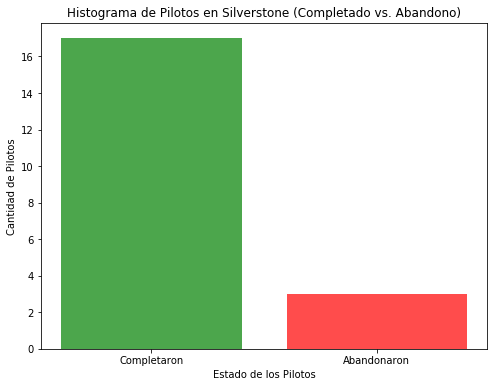

   Distribución         Error
0      bradford  2.208601e+06
1          beta  1.295673e+27
2         expon           NaN
3     exponnorm  3.809064e+44
4          norm           NaN
5       uniform           NaN
6      foldnorm  8.016139e+45
7       gennorm  3.211326e+47
8         ksone  1.448118e+43
9        kappa4  2.487723e+27
10    johnsonsb  1.500000e+01


In [35]:
def histo(Silverstone_GP):
    # Define el número total de vueltas requeridas
    vueltas_totales = 26

    # Encuentra el último registro de cada piloto
    ultimo_registro = Silverstone_GP.groupby('driverId')['currentLapNum'].max().reset_index()

    # Filtra los pilotos que completaron exactamente las 27 vueltas y los que abandonaron
    completaron = ultimo_registro[ultimo_registro['currentLapNum'] == vueltas_totales]
    abandonaron = ultimo_registro[ultimo_registro['currentLapNum'] != vueltas_totales]

    # Crea el histograma
    plt.figure(figsize=(8, 6))
    plt.bar(['Completaron', 'Abandonaron'], [len(completaron), len(abandonaron)], color=['green', 'red'], alpha=0.7)
    plt.xlabel("Estado de los Pilotos")
    plt.ylabel("Cantidad de Pilotos")
    plt.title("Histograma de Pilotos en Silverstone (Completado vs. Abandono)")
    plt.show()

    # Datos para calcular errores
    y, x = np.histogram(completaron['currentLapNum'], bins=15, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2

    # Inicializa un DataFrame para los errores
    error_df = pd.DataFrame(columns=['Distribución', 'Error'])

    # Lista de distribuciones de probabilidad
    dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

    # Ajusta y calcula errores para cada distribución
    for dist_name in dist_list:
        dist = getattr(st, dist_name)
        params = dist.fit(completaron['currentLapNum'])
        y_hat = dist.pdf(x, *params)
        error = np.mean((y - y_hat) ** 2)
        error_df = error_df.append({'Distribución': dist_name, 'Error': error}, ignore_index=True)

    # Muestra la tabla de errores
    print(error_df)

# Llama a la función con tus datos
histo(Silverstone_GP)

In [36]:
def remove_outliers2(sim_data,columna):
    Q1 = sim_data[columna].quantile(0.25)
    Q3 = sim_data[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    s_data = sim_data[(sim_data[columna] >= lower_limit) & (sim_data[columna] <= upper_limit)]
    
    return s_data,lower_limit,upper_limit

In [37]:
def rectangular_KDE(dataframe,columna,label):
    datos, ll, ul = remove_outliers2(dataframe,columna)
    b = datos[columna].values
    kde = st.gaussian_kde(b, bw_method='silverman')  # bw_method es el ancho de banda

    # Generar puntos de la gráfica para el KDE
    x = np.linspace(np.min(b), np.max(b), 1000)
    y = kde.evaluate(x)

    # Gráfico del KDE con kernel rectangular
    plt.plot(x, y, label=label, color='blue')
    plt.fill_between(x, 0, y, alpha=0.5, color='blue')  # Relleno bajo la curva

    # Mostrar el gráfico
    plt.title('KDE con Kernel Rectangular')
    plt.xlabel('Tiempo (s)')
    plt.legend()
    plt.show()

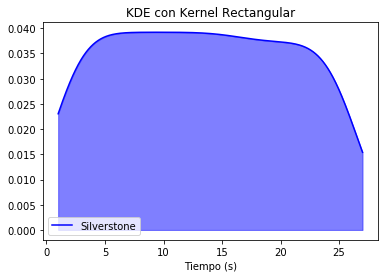

In [38]:
rectangular_KDE(Silverstone_GP,'currentLapNum','Silverstone')

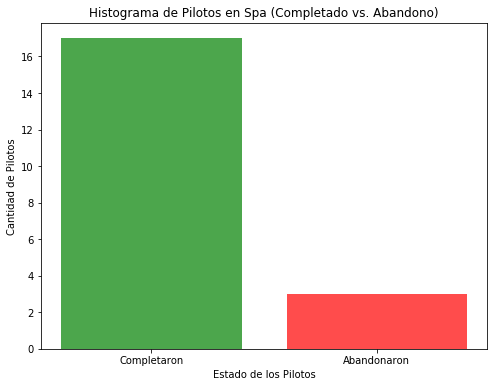

   Distribución         Error
0      bradford  2.208602e+06
1          beta  3.161659e+26
2         expon           NaN
3     exponnorm  4.827574e+42
4          norm           NaN
5       uniform           NaN
6      foldnorm  5.647136e+41
7       gennorm  3.981264e+42
8         ksone  5.188903e+41
9        kappa4  1.649298e+27
10    johnsonsb  1.500000e+01


In [43]:
def histo(Spa_GP):
    # Define el número total de vueltas requeridas
    vueltas_totales = 22

    # Encuentra el último registro de cada piloto
    ultimo_registro = Spa_GP.groupby('driverId')['currentLapNum'].max().reset_index()

    # Filtra los pilotos que completaron exactamente las 27 vueltas y los que abandonaron
    completaron = ultimo_registro[ultimo_registro['currentLapNum'] == vueltas_totales]
    abandonaron = ultimo_registro[ultimo_registro['currentLapNum'] != vueltas_totales]

    # Crea el histograma
    plt.figure(figsize=(8, 6))
    plt.bar(['Completaron', 'Abandonaron'], [len(completaron), len(abandonaron)], color=['green', 'red'], alpha=0.7)
    plt.xlabel("Estado de los Pilotos")
    plt.ylabel("Cantidad de Pilotos")
    plt.title("Histograma de Pilotos en Spa (Completado vs. Abandono)")
    plt.show()

    # Datos para calcular errores
    y, x = np.histogram(completaron['currentLapNum'], bins=15, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2

    # Inicializa un DataFrame para los errores
    error_df = pd.DataFrame(columns=['Distribución', 'Error'])

    # Lista de distribuciones de probabilidad
    dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

    # Ajusta y calcula errores para cada distribución
    for dist_name in dist_list:
        dist = getattr(st, dist_name)
        params = dist.fit(completaron['currentLapNum'])
        y_hat = dist.pdf(x, *params)
        error = np.mean((y - y_hat) ** 2)
        error_df = error_df.append({'Distribución': dist_name, 'Error': error}, ignore_index=True)

    # Muestra la tabla de errores
    print(error_df)

# Llama a la función con tus datos
histo(Spa_GP)

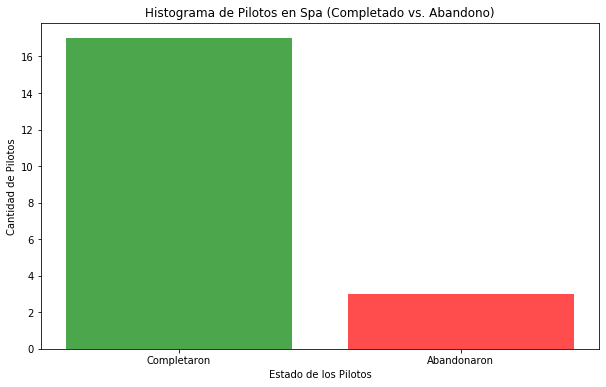

In [39]:
# Define el número total de vueltas requeridas
vueltas_totales = 22

# Encuentra el último registro de cada piloto
ultimo_registro = Spa_GP.groupby('driverId')['currentLapNum'].max().reset_index()

# Filtra los pilotos que completaron exactamente las 39 vueltas y los que abandonaron
completaron = ultimo_registro[ultimo_registro['currentLapNum'] == vueltas_totales]
abandonaron = ultimo_registro[ultimo_registro['currentLapNum'] != vueltas_totales]

# Crea el histograma
plt.figure(figsize=(10, 6))
plt.bar(['Completaron', 'Abandonaron'], [len(completaron), len(abandonaron)], color=['green', 'red'], alpha=0.7)
plt.xlabel("Estado de los Pilotos")
plt.ylabel("Cantidad de Pilotos")
plt.title("Histograma de Pilotos en Spa (Completado vs. Abandono)")
plt.show()

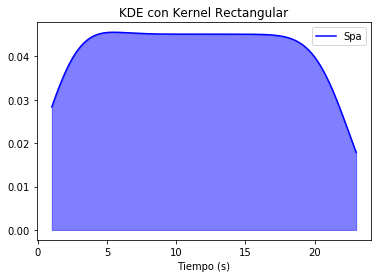

In [40]:
rectangular_KDE(Spa_GP,'currentLapNum','Spa')

## Simulación

## Generación de PDF

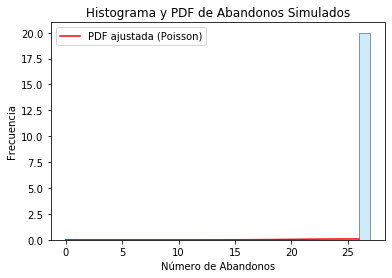

In [51]:
# Número total de vueltas requeridas
vueltas_totales = 26

# Obtén los pilotos únicos en el DataFrame
pilotos_unicos = Silverstone_GP['driverId'].unique()

# Inicializa un diccionario para realizar un seguimiento de los pilotos que abandonaron
abandonos_por_piloto = {piloto: 0 for piloto in pilotos_unicos}

# Número de simulaciones
num_simulaciones = 10000

# Realiza la simulación
for _ in range(num_simulaciones):
    for piloto in pilotos_unicos:
        # Verifica si el piloto abandona o completa la carrera
        abandona = False
        if piloto in abandonos_por_piloto:
            abandonos_previos = abandonos_por_piloto[piloto]
            if abandonos_previos < vueltas_totales:
                abandona = True
                abandonos_por_piloto[piloto] += 1
        else:
            abandonos_por_piloto[piloto] = 1 if piloto not in abandonos_por_piloto else 0

# Obtén la cantidad de abandonos por piloto
abandonos_pilotos = list(abandonos_por_piloto.values())

# Ajustar una distribución de Poisson a los datos
mu, std = np.mean(abandonos_pilotos), np.std(abandonos_pilotos)
distribucion_poisson = poisson(mu)

# Generar datos para la PDF ajustada
x = np.arange(0, vueltas_totales + 1)
pdf_ajustada = distribucion_poisson.pmf(x)

# Crear un histograma con KDE
sns.distplot(abandonos_pilotos, bins=range(vueltas_totales + 2), kde=False, color='skyblue', hist_kws={'edgecolor':'black'})

# Graficar la PDF ajustada
plt.plot(x, pdf_ajustada, 'r-', label='PDF ajustada (Poisson)')

# Personalizar el gráfico
plt.title('Histograma y PDF de Abandonos Simulados')
plt.xlabel('Número de Abandonos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

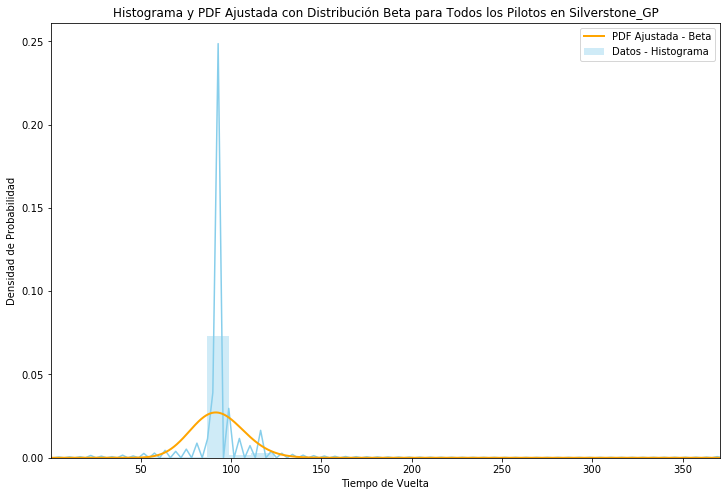

Parámetros para la distribución Beta: (90.59937949989256, 30896295.65968746, -47.127580473028885, 47790374.95930067)


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

# Obtén todos los tiempos de vuelta de Silverstone_GP
tiempos_vuelta_silverstonegp = Silverstone_GP['LapTime']

# Ajusta la distribución Beta
parametros_beta = st.beta.fit(tiempos_vuelta_silverstonegp)

# Crear gráfica de histograma y PDF ajustada
plt.figure(figsize=(12, 8))

# Histograma
sns.distplot(tiempos_vuelta_silverstonegp, bins=30, kde=True, color='skyblue', label='Datos - Histograma')

# PDF ajustada
x = np.linspace(min(tiempos_vuelta_silverstonegp), max(tiempos_vuelta_silverstonegp), 1000)
pdf_ajustada = st.beta.pdf(x, *parametros_beta)
plt.plot(x, pdf_ajustada, label='PDF Ajustada - Beta', color='orange', linewidth=2)

plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad de Probabilidad')
plt.title('Histograma y PDF Ajustada con Distribución Beta para Todos los Pilotos en Silverstone_GP')
plt.legend()

# Ajustar límites del eje x para hacer zoom
plt.xlim(min(tiempos_vuelta_silverstonegp), max(tiempos_vuelta_silverstonegp))

plt.show()

# Imprimir parámetros de la distribución ajustada
print(f'Parámetros para la distribución Beta: {parametros_beta}')


In [52]:
# Define el número total de vueltas requeridas
vueltas_totales = 22

# Obtén los pilotos únicos en el DataFrame
pilotos_unicos = Spa_GP['driverId'].unique()

# Inicializa un diccionario para realizar un seguimiento de los pilotos que abandonaron
abandonos_por_piloto = {piloto: 0 for piloto in pilotos_unicos}

# Número de simulaciones
num_simulaciones = 10000

# Realiza la simulación
for _ in range(num_simulaciones):
    for piloto in pilotos_unicos:
        # Verifica si el piloto abandona o completa la carrera
        abandona = False
        if piloto in abandonos_por_piloto:
            abandonos_previos = abandonos_por_piloto[piloto]
            if abandonos_previos < vueltas_totales:
                abandona = True
                abandonos_por_piloto[piloto] += 1
        else:
            abandonos_por_piloto[piloto] = 1 if piloto not in abandonos_por_piloto else 0
        
# Encuentra el piloto que más veces abandonó
piloto_mas_probable_abandonar = max(abandonos_por_piloto, key=abandonos_por_piloto.get)

# Imprimir el piloto más probable de abandonar
print("Piloto más probable de abandonar:", piloto_mas_probable_abandonar)

Piloto más probable de abandonar: Lance Stroll


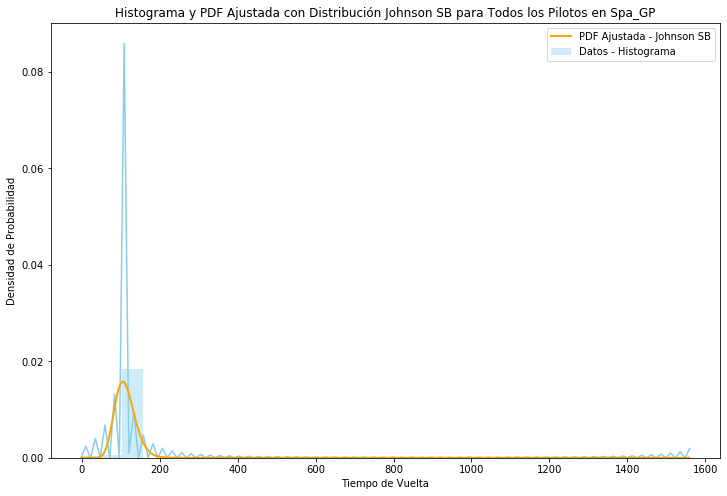

Parámetros para la distribución Johnson SB: (29.162480717097516, 5.989813817133378, -44.88939679727706, 20258.48117452056)


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

# Obtén todos los tiempos de vuelta de Spa_GP
tiempos_vuelta_spagp = Spa_GP['LapTime']

# Ajusta la distribución Johnson SB
parametros_johnsonsb = st.johnsonsb.fit(tiempos_vuelta_spagp)

# Crear gráfica de histograma y PDF ajustada
plt.figure(figsize=(12, 8))

# Histograma
sns.distplot(tiempos_vuelta_spagp, bins=30, kde=True, color='skyblue', label='Datos - Histograma')

# PDF ajustada
x = np.linspace(min(tiempos_vuelta_spagp), max(tiempos_vuelta_spagp), 1000)
pdf_ajustada = st.johnsonsb.pdf(x, *parametros_johnsonsb)
plt.plot(x, pdf_ajustada, label='PDF Ajustada - Johnson SB', color='orange', linewidth=2)

plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad de Probabilidad')
plt.title('Histograma y PDF Ajustada con Distribución Johnson SB para Todos los Pilotos en Spa_GP')
plt.legend()
plt.show()

# Imprimir parámetros de la distribución ajustada
print(f'Parámetros para la distribución Johnson SB: {parametros_johnsonsb}')


In [ ]:
# Número total de vueltas requeridas
vueltas_totales = 22

# Obtén los pilotos únicos en el DataFrame
pilotos_unicos = Spa_GP['driverId'].unique()

# Inicializa un diccionario para realizar un seguimiento de los pilotos que abandonaron
abandonos_por_piloto = {piloto: 0 for piloto in pilotos_unicos}

# Número de simulaciones
num_simulaciones = 10000

# Realiza la simulación
for _ in range(num_simulaciones):
    for piloto in pilotos_unicos:
        # Verifica si el piloto abandona o completa la carrera
        abandona = False
        if piloto in abandonos_por_piloto:
            abandonos_previos = abandonos_por_piloto[piloto]
            if abandonos_previos < vueltas_totales:
                abandona = True
                abandonos_por_piloto[piloto] += 1
        else:
            abandonos_por_piloto[piloto] = 1 if piloto not in abandonos_por_piloto else 0

# Obtén la cantidad de abandonos por piloto
abandonos_pilotos = list(abandonos_por_piloto.values())

# Ajustar una distribución de Poisson a los datos
mu, std = np.mean(abandonos_pilotos), np.std(abandonos_pilotos)
distribucion_poisson = poisson(mu)

# Generar datos para la PDF ajustada
x = np.arange(0, vueltas_totales + 1)
pdf_ajustada = distribucion_poisson.pmf(x)

# Crear un histograma con KDE
sns.distplot(abandonos_pilotos, bins=range(vueltas_totales + 2), kde=False, color='skyblue', hist_kws={'edgecolor':'black'})

# Graficar la PDF ajustada
plt.plot(x, pdf_ajustada, 'r-', label='PDF ajustada (Poisson)')

# Personalizar el gráfico
plt.title('Histograma y PDF de Abandonos Simulados')
plt.xlabel('Número de Abandonos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()